<center><b><h1> Twitter Sentiment Analysis </h1></b></center>

In [41]:
#import neccessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import plotly as py
import cufflinks as cf

from plotly.offline import iplot
py.offline.init_notebook_mode(connected = True)
cf.go_offline()

from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

from wordcloud import WordCloud, STOPWORDS
import pickle
import time

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import preprocessing
import xgboost as xgb
from sklearn.ensemble import VotingClassifier

import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()
from spacy.lang.en.stop_words import STOP_WORDS
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [42]:
df = pd.read_csv("C:/Users/ASUS/Downloads/CoronaTweetsSentimentAnalysis.csv")

In [43]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
1,2,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
2,3,44959,NaN,03-03-2020,Voting in the age of #coronavirus = hand sanit...,Positive
3,4,44963,"Boksburg, South Africa",04-03-2020,Best quality couches at unbelievably low price...,Positive
4,5,44967,"Washington, DC",04-03-2020,While we were busy watching election returns a...,Positive


In [44]:
#Look at shape of the data
print(df.shape)
#How many values are null in each columns
print(df.isnull().sum())

(1988, 6)
UserName           0
ScreenName         0
Location         452
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64


In [45]:
#Label values
df['Sentiment'].value_counts()

Negative    1041
Positive     947
Name: Sentiment, dtype: int64

In [46]:
df['Tweet'] = pd.Series(df[['OriginalTweet','Location']].fillna('').values.tolist()).str.join(' ')
df.drop(['UserName','ScreenName','TweetAt','OriginalTweet','Location'],axis = 1, inplace = True)
df.head()

,Sentiment,Tweet
0,Positive,When I couldn't find hand sanitizer at Fred Me...
1,Negative,#Panic buying hits #NewYork City as anxious sh...
2,Positive,Voting in the age of #coronavirus = hand sanit...
3,Positive,Best quality couches at unbelievably low price...
4,Positive,While we were busy watching election returns a...


In [47]:
df['Tweet'][3]

'Best quality couches at unbelievably low prices available to order.\r\r\n\r\r\nWe are in Boksburg GP \r\r\n\r\r\nFor more info WhatsApp:\r\r\n084 764 8086\r\r\n\r\r\n#SuperTuesdsy #PowerTalk \r\r\n#Covid_19 #SayEntrepreneur \r\r\n#DJSBU https://t.co/HhDJhyQ2Dc Boksburg, South Africa'

In [48]:
df1 = df[['Tweet','Sentiment']]

In [49]:
def get_avg_word_len(x):
    words = x.split()
    word_len = 0
    for word in words:
        word_len = word_len + len(word)
    return word_len/len(words)

In [50]:
df1['text_len'] = df1['Tweet'].apply(lambda x: len(x))
df1['word_count'] = df1['Tweet'].apply(lambda x: len(x.split()))
df1['avg_word_len'] = df1['Tweet'].apply(lambda x: get_avg_word_len(x))

In [51]:
df1.head()

,Tweet,Sentiment,text_len,word_count,avg_word_len
0,When I couldn't find hand sanitizer at Fred Me...,Positive,205,32,5.406250
1,#Panic buying hits #NewYork City as anxious sh...,Negative,330,38,7.368421
2,Voting in the age of #coronavirus = hand sanit...,Positive,91,12,6.583333
3,Best quality couches at unbelievably low price...,Positive,256,31,6.516129
4,While we were busy watching election returns a...,Positive,212,28,6.607143


## Exploratory data analysis

### Distribution of Questions based on Quality

Text(0, 0.5, 'Count')

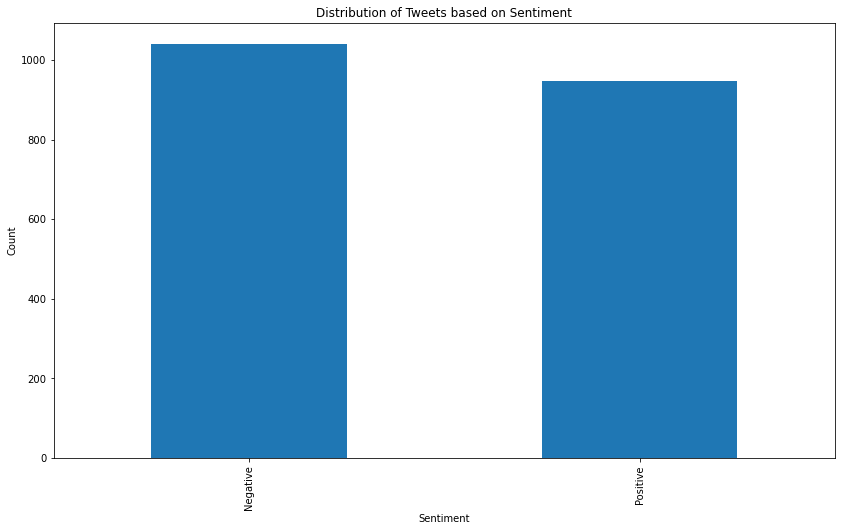

In [52]:
ax = df1['Sentiment'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Distribution of Tweets based on Sentiment")
ax.set_xlabel("Sentiment")
ax.set_ylabel("Count")

### Distrubution of Question length

Text(0, 0.5, 'Count')

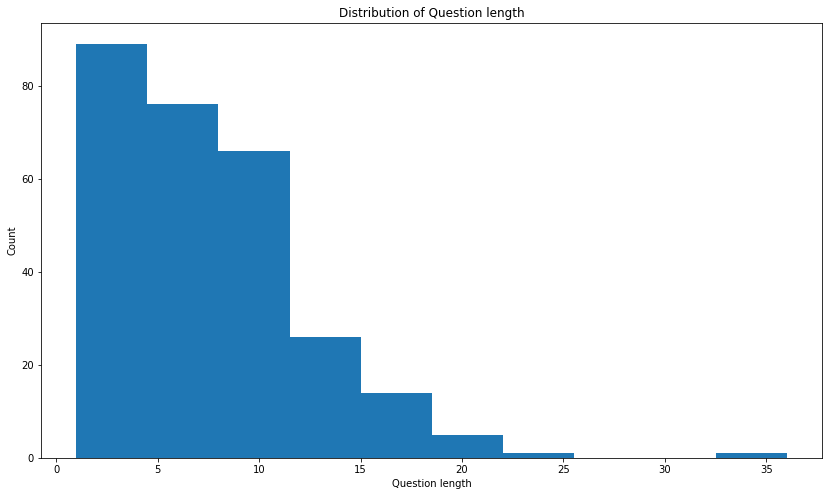

In [53]:

ax = df1['text_len'].value_counts().plot(kind='hist',
                                    figsize=(14,8),
                                    title="Distribution of Question length")
ax.set_xlabel("Question length")
ax.set_ylabel("Count")

### Distribution of No.of words in a Question

Text(0, 0.5, 'Count')

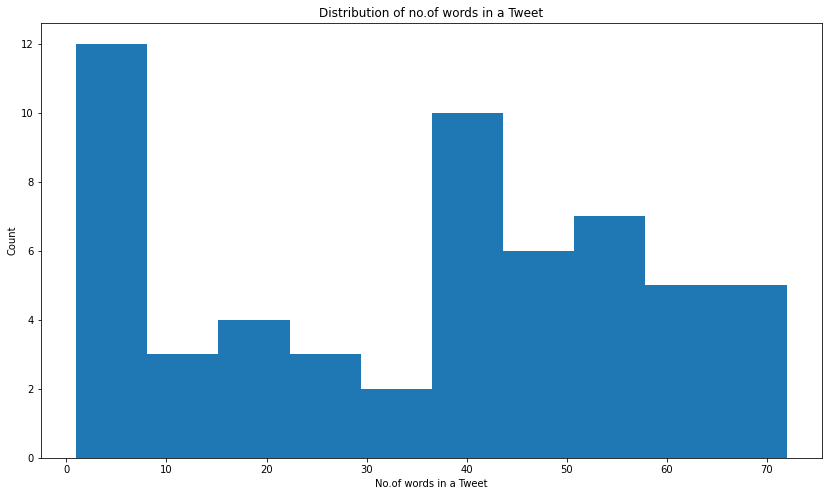

In [54]:

ax = df1['word_count'].value_counts().plot(kind='hist',
                                    figsize=(14,8),
                                    title="Distribution of no.of words in a Tweet")
ax.set_xlabel("No.of words in a Tweet")
ax.set_ylabel("Count")

### Distribution of Average word length in Questions

Text(0, 0.5, 'Count')

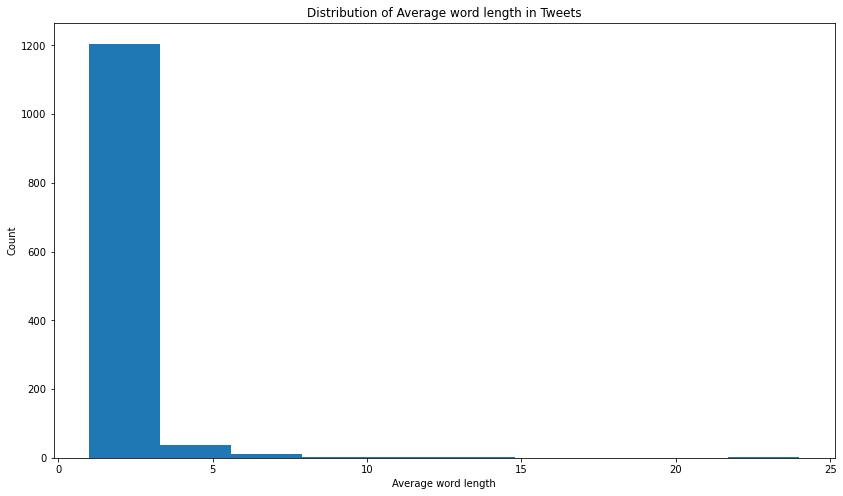

In [55]:

ax = df1['avg_word_len'].value_counts().plot(kind='hist',
                                    figsize=(14,8),
                                    title="Distribution of Average word length in Tweets")
ax.set_xlabel("Average word length")
ax.set_ylabel("Count")

In [56]:
def get_top_n_words(x,ngram,top):
    vec = CountVectorizer(ngram_range = (ngram,ngram)).fit(x)
    bow = vec.transform(x)
    sum_words = bow.sum(axis = 0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =  sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:top]

In [57]:
words = get_top_n_words(df1['Tweet'],1,20)

In [58]:
words

[('the', 2330),
 ('to', 1969),
 ('and', 1284),
 ('of', 1113),
 ('in', 1021),
 ('co', 931),
 ('https', 916),
 ('covid_19', 799),
 ('coronavirus', 777),
 ('food', 742),
 ('for', 697),
 ('is', 669),
 ('you', 612),
 ('on', 606),
 ('are', 582),
 ('store', 528),
 ('at', 471),
 ('grocery', 447),
 ('19', 443),
 ('it', 440)]

### Distribution of Unigram,Bigram and Trigram without STOPWORDS

In [59]:
def get_top_n_words(x,ngram,top):
    vec = CountVectorizer(ngram_range = (ngram,ngram),stop_words = 'english').fit(x)
    bow = vec.transform(x)
    sum_words = bow.sum(axis = 0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =  sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:top]

In [60]:
words = get_top_n_words(df1['Tweet'],1,20)

### Distribution of Top 20 Unigrams based on Frequency

Text(0, 0.5, 'Count')

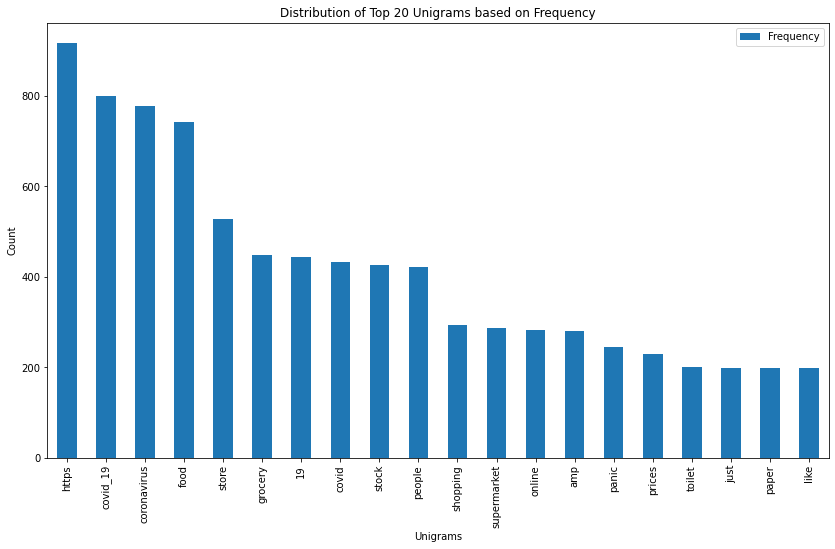

In [61]:
df2 = pd.DataFrame(words, columns = ['Unigram','Frequency'])
df2 = df2.set_index('Unigram')


ax = df2.plot(kind='bar',figsize=(14,8),
                                    title="Distribution of Top 20 Unigrams based on Frequency")
ax.set_xlabel("Unigrams")
ax.set_ylabel("Count")


In [62]:
words = get_top_n_words(df1['Tweet'],2,20)

### Distribution of Top 20 Bigrams based on Frequency

Text(0, 0.5, 'Count')

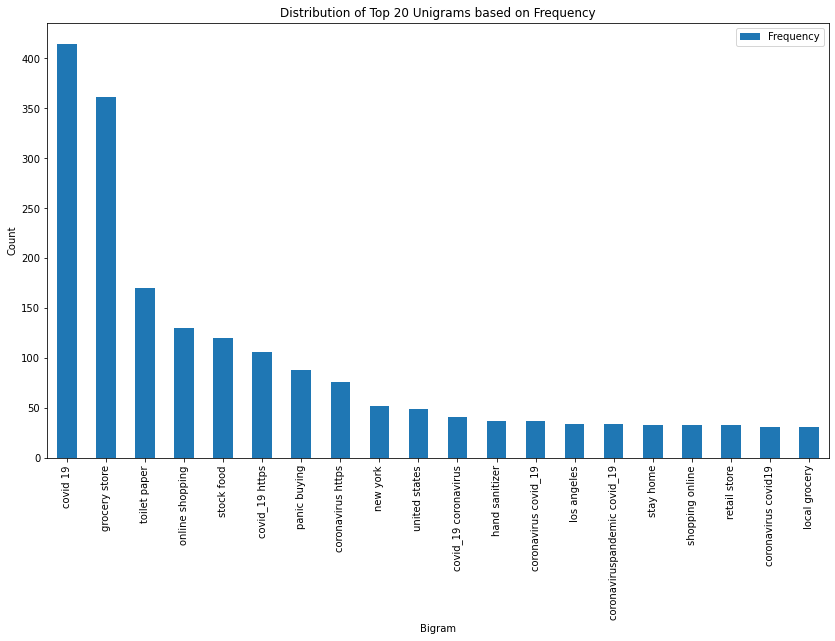

In [63]:
df2 = pd.DataFrame(words, columns = ['Bigram','Frequency'])
df2 = df2.set_index('Bigram')
ax = df2.plot(kind='bar',figsize=(14,8),
                                    title="Distribution of Top 20 Unigrams based on Frequency")
ax.set_xlabel("Bigram")
ax.set_ylabel("Count")

In [64]:
words = get_top_n_words(df1['Tweet'],3,20)

### Distribution of Top 20 Trigrams based on Frequency

Text(0, 0.5, 'Count')

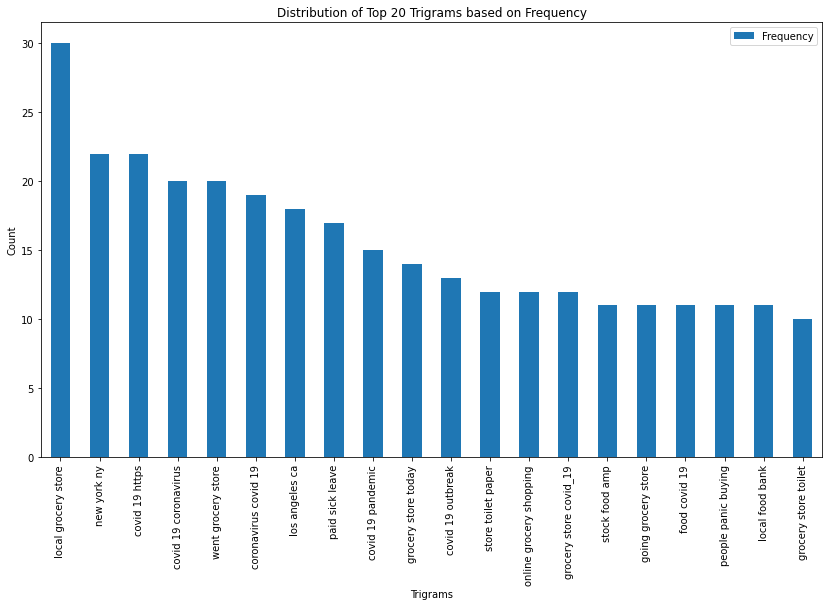

In [65]:
df2 = pd.DataFrame(words, columns = ['Trigram','Frequency'])
df2 = df2.set_index('Trigram')
ax = df2.plot(kind='bar', figsize=(14,8),
                                    title="Distribution of Top 20 Trigrams based on Frequency")
ax.set_xlabel("Trigrams")
ax.set_ylabel("Count")

### Bivariate Analysis of Numerical Columns

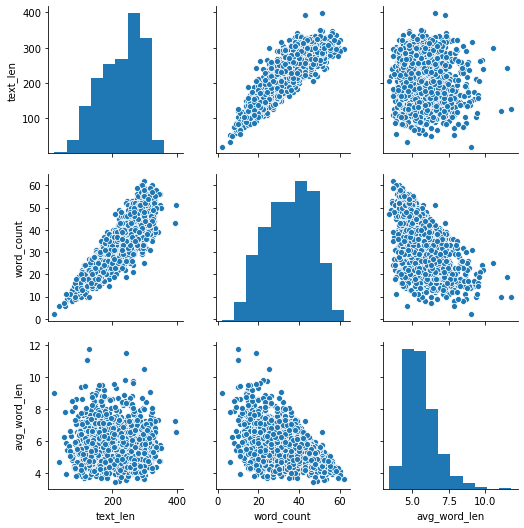

In [26]:
sns.pairplot(df1)

### Relationship between Quality of Questions and Word Count

Text(0.5, 0.98, 'Relationship between Sentiment and Word Count')

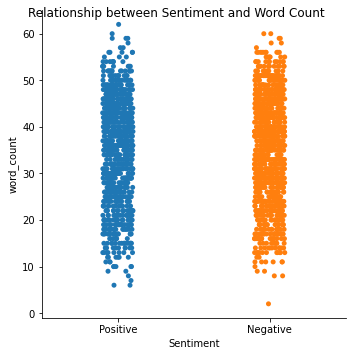

In [27]:
plot = sns.catplot(x = 'Sentiment', y='word_count', data=df1)
plot.fig.suptitle('Relationship between Sentiment and Word Count')

From the above, we can say that Word count does not have much influence on Sentiment of the tweets.

## Text Cleaning

### Counting emails

In [28]:
df1['emails'] = df1['Tweet'].apply(lambda x: re.findall(r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)', x))
df1['emails_count'] = df1['emails'].apply(lambda x: len(x))

In [29]:
df1[df1['emails_count']>0].head()

,Tweet,Sentiment,text_len,word_count,avg_word_len,emails,emails_count
16,So far 36 Pennsylvanians have reached out to m...,Negative,280,38,6.236842,[pricegouging@attorneygeneral.gov],1
261,"U.S. World Food Prices Fell During February: ""...",Negative,309,49,5.224490,[info@farms.com],1
415,Has anyone in #Cardiff or #SouthWales had thei...,Negative,313,45,5.711111,[rhiannon.c.moore@icloud.com],1
1001,Be vigilant about scam calls regarding the Cov...,Negative,274,37,6.405405,[consumerhelp@state.sd.us],1
1098,Report retailers or manufacturers colluding &a...,Positive,262,34,6.735294,[info@cak.go.ke],1


### Counting URLs

In [30]:
df1['urls_flag'] = df1['Tweet'].apply(lambda x: len(re.findall(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', x)))

In [31]:
df1[df1['urls_flag'] > 0].head()

,Tweet,Sentiment,text_len,word_count,avg_word_len,emails,emails_count,urls_flag
0,When I couldn't find hand sanitizer at Fred Me...,Positive,205,32,5.406250,[],0,1
1,#Panic buying hits #NewYork City as anxious sh...,Negative,330,38,7.368421,[],0,2
2,Voting in the age of #coronavirus = hand sanit...,Positive,91,12,6.583333,[],0,1
3,Best quality couches at unbelievably low price...,Positive,256,31,6.516129,[],0,1
4,While we were busy watching election returns a...,Positive,212,28,6.607143,[],0,1


In [32]:
#Cleaning tet by converting text to lowecase,removing emails,urls,html tags,spaces,punctuations,numbers and stop words
def cleaning_text(text):
    #Converting to lowercase
    text = text.lower()
    #Removing emails
    text = re.sub(r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)', '', text)
    #Removing URLs
    text = re.sub(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', text)
    #Removing HTML tags
    text = BeautifulSoup(text, 'lxml').get_text()
    #Removing punctuations and numbers
    text = re.sub('[^A-Z a-z ]+', ' ', text)
    #Removing Multiple spaces
    text =  " ".join(text.split())
    #Removing Stop words
    text =  " ".join([t for t in text.split() if t not in STOP_WORDS])
    return text

In [33]:
#Dropping unnecessary columns
df1 = df1.drop(['emails','emails_count','urls_flag'], axis = 1)
#Cleaning Text
df1['Tweet'] = df1['Tweet'].apply(lambda x: cleaning_text(x))
#Dropping duplicate values
df1 = df1.drop_duplicates(subset=["Tweet","Sentiment"])

In [34]:
i = 20
print(df['Tweet'][i],"\n\n\n\n\n",df1['Tweet'][i])





 ?? ???? ?????? . ??? ???? ??? 




 realdonaldtrump separate table corna virus statistics high stats corona virus government s inability control corona virus high price disinfectant gel usa high price mask usa food prices rising day day


In [35]:
text = ' '.join(df1['Tweet'])
text = text.split()
len(text)

38981

### Most frequent words

In [36]:
freq_comm = pd.Series(text).value_counts()
freq_comm[:20]

covid          1533
coronavirus     776
food            746
store           528
grocery         447
s               439
t               429
stock           425
people          421
shopping        292
supermarket     287
online          280
panic           244
prices          230
toilet          201
paper           197
like            197
need            183
don             174
buying          156
dtype: int64

In [37]:
#Removing characters since it may be often used as variables
df1['Tweet'] = df1['Tweet'].apply(lambda x: " ".join([t for t in x.split() if len(t) > 1]))

In [38]:
f10 = freq_comm[:10]
df1['Tweet'] = df1['Tweet'].apply(lambda x: " ".join([t for t in x.split() if t not in f10[:10]]))#Removing most frequent words

### Removing rare words

In [39]:
rare = freq_comm[freq_comm.values == 1]
df1['Tweet'] = df1['Tweet'].apply(lambda x: ' '.join([t for t in x.split() if t not in rare]))

In [40]:
text = ' '.join(df1['Tweet'])
text = text.split()
len(set(text))

3442

### TF - IDF Vectorizer

In [41]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english')
tfIdfMat  = vectorizer.fit_transform(df1['Tweet'].tolist())

In [42]:
feature_names = sorted(vectorizer.get_feature_names())
#print(feature_names)

In [43]:
len(feature_names)

3431

In [44]:
from sklearn.model_selection import train_test_split

labels = df1['Sentiment'].tolist()
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat, labels, test_size=0.33,random_state=42)

In [45]:
log = LogisticRegression()
log.fit(X_train,y_train)
predictions = log.predict(X_test)
print(metrics.accuracy_score(y_test,predictions))
print(metrics.classification_report(y_test,predictions))

0.6402439024390244
              precision    recall  f1-score   support

    Negative       0.63      0.73      0.68       341
    Positive       0.65      0.54      0.59       315

    accuracy                           0.64       656
   macro avg       0.64      0.64      0.63       656
weighted avg       0.64      0.64      0.64       656



In [46]:
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(metrics.accuracy_score(y_test,y_pred))
print(metrics.classification_report(y_test,y_pred))

0.635670731707317
              precision    recall  f1-score   support

    Negative       0.62      0.77      0.69       341
    Positive       0.66      0.49      0.56       315

    accuracy                           0.64       656
   macro avg       0.64      0.63      0.63       656
weighted avg       0.64      0.64      0.63       656



In [47]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
y_pred_dtree = dtree.predict(X_test)
print(metrics.accuracy_score(y_test,y_pred_dtree))
print(metrics.classification_report(y_test,y_pred_dtree))

0.6021341463414634
              precision    recall  f1-score   support

    Negative       0.61      0.66      0.63       341
    Positive       0.59      0.54      0.57       315

    accuracy                           0.60       656
   macro avg       0.60      0.60      0.60       656
weighted avg       0.60      0.60      0.60       656



In [48]:
clf=RandomForestClassifier(n_estimators=100)    #Create a Gaussian Classifier
clf.fit(X_train,y_train)     #Train the model using the training sets y_pred=clf.predict(X_test)
y_pred_rf=clf.predict(X_test)
print(metrics.accuracy_score(y_test,y_pred_rf))
print(metrics.classification_report(y_test,y_pred_rf))

0.6204268292682927
              precision    recall  f1-score   support

    Negative       0.60      0.82      0.69       341
    Positive       0.67      0.41      0.51       315

    accuracy                           0.62       656
   macro avg       0.64      0.61      0.60       656
weighted avg       0.63      0.62      0.60       656



### Word Embedding with word2vec

In [49]:
def get_vec(x):
    doc = nlp(x)
    vec = doc.vector
    return vec

In [50]:
df1['vec'] = df1['Tweet'].apply(lambda x: get_vec(x))
df1.head()

,Tweet,Sentiment,text_len,word_count,avg_word_len,vec
0,couldn find hand sanitizer fred meyer amazon p...,Positive,205,32,5.406250,"[-0.2030265, 0.07947565, -0.02712057, -0.06036..."
1,panic buying hits newyork city anxious shopper...,Negative,330,38,7.368421,"[-0.01406505, 0.09977359, 0.0059688976, -0.029..."
2,age hand sanitizer,Positive,91,12,6.583333,"[-0.46513334, 0.04096665, 0.116428666, -0.0849..."
3,best low prices available order boksburg info ...,Positive,256,31,6.516129,"[-0.19799939, 0.19754182, 0.085628636, -0.0532..."
4,busy watching election returns bracing outbrea...,Positive,212,28,6.607143,"[-0.11161437, 0.15552333, 0.13277888, -0.10643..."


In [51]:
pickle.dump(df1,open('clean_data.pkl','wb'))

In [52]:
df1 = pickle.load(open('clean_data.pkl','rb'))

In [53]:
X = df1['vec'].to_numpy()
X = X.reshape(-1, 1)

In [54]:
X.shape

(1987, 1)

In [55]:
X = np.concatenate(np.concatenate(X, axis = 0), axis = 0).reshape(-1, 300)

In [56]:
X.shape

(1987, 300)

In [57]:
y = df1['Sentiment']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [59]:
X_train.shape, X_test.shape

((1589, 300), (398, 300))

## Logistic Regression

In [60]:
log = LogisticRegression()
log.fit(X_train,y_train)

LogisticRegression()

In [61]:
pickle.dump(log,open('logistic_train.pkl','wb'))

In [62]:
log = pickle.load(open('logistic_train.pkl','rb'))

In [63]:
y_pred = log.predict(X_test)

In [64]:
print("Logistic Regression:\nAccuracy: ",metrics.accuracy_score(y_test,y_pred))

Logistic Regression:
Accuracy:  0.6306532663316583


<h2>Naive Bayes</h2>

In [65]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred  =  nb.predict(X_test)

In [66]:
pickle.dump(nb,open('naive_train.pkl','wb'))

In [67]:
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.accuracy_score(y_test,y_pred))

[[126  86]
 [ 76 110]]
0.592964824120603


<h2>Decision Tree</h2>

In [68]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
y_pred_dtree = dtree.predict(X_test)

In [69]:
pickle.dump(dtree,open('dtree_train.pkl','wb'))

In [70]:
dtree = pickle.load(open('dtree_train.pkl','rb'))

In [71]:
print("Decision Tree:\nAccuracy: ",metrics.accuracy_score(y_test,y_pred_dtree))

Decision Tree:
Accuracy:  0.5125628140703518


<h2>Random Forest Classification</h2>

In [72]:
clf=RandomForestClassifier(n_estimators=100)    #Create a Gaussian Classifier
clf.fit(X_train,y_train)     #Train the model using the training sets y_pred=clf.predict(X_test)
y_pred_rf=clf.predict(X_test)

In [73]:
pickle.dump(clf,open('randomforest_train.pkl','wb'))

In [74]:
clf = pickle.load(open('randomforest_train.pkl','rb'))

In [75]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_rf))

Accuracy: 0.6105527638190955


<h2>XGBoost Classifier</h2>

In [76]:
label_encoder = preprocessing.LabelEncoder()
y_code = label_encoder.fit_transform(df1['Sentiment'])
ytrain_code = label_encoder.fit_transform(y_train)
ytest_code = label_encoder.fit_transform(y_test)

In [77]:
data_dmatrix = xgb.DMatrix(data=X,label=y_code)

In [78]:
xg_reg = xgb.XGBClassifier(objective ='multi:softmax', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10,num_class=3)
xg_reg.fit(X_train,ytrain_code)
preds = xg_reg.predict(X_test)

In [79]:
pickle.dump(xg_reg,open('xgb_train.pkl','wb'))

In [80]:
xg_reg = pickle.load(open('xgb_train.pkl','rb'))

In [81]:
rmse = np.sqrt(metrics.mean_squared_error(ytest_code, preds))
print("RMSE: %f" % (rmse))
#predictions = [round(value) for value in preds]
print("Accuracy: ",metrics.accuracy_score(ytest_code,preds))

RMSE: 0.663098
Accuracy:  0.5603015075376885


<h2>Giving input and Prediction</h2>

In [82]:
input = [['''"Form Validation project<p>I am working on a project for my company and we are not allowed to alter the HTML in any way. There is already a Page set up in the Using html to do Data Validation. There are to separate forms of validation questions on the page and each form contains its own ""submit"" button. Although both submit buttons have the same ""id"". is there any way to figure out how isolate each button to apply a different "".onclick"" method to them. Thanks in advance.</p>
"
'''],[''' ''']]
   

#Tf-idf vectorizer
for i in input:
    print(log.predict(vectorizer.transform([str(i)])))

# LSTM and Bidirectional LSTM

In [84]:
import gensim
from nltk.tokenize.treebank import TreebankWordDetokenizer

In [85]:
df = pd.read_csv("CoronaTweetsSentimentAnalysis.csv")
df['Tweet'] = pd.Series(df[['OriginalTweet','Location']].fillna('').values.tolist()).str.join(' ')
df.drop(['UserName','ScreenName','TweetAt','OriginalTweet','Location'],axis = 1, inplace = True)

In [86]:
temp = []
#Splitting pd.Series to list
data_to_list = df['Tweet'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(cleaning_text(data_to_list[i]))

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
data_words = list(sent_to_words(temp))

def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['couldn find hand sanitizer fred meyer turned amazon pack purell check coronavirus concerns driving prices seattle wa', 'panic buying hits newyork city anxious shoppers stock food medical supplies healthcare worker bigapple st confirmed coronavirus patient bloomberg staged event qanon qanon qanon election cdc chicagoland', 'voting age coronavirus hand sanitizer supertuesday', 'best quality couches unbelievably low prices available order boksburg gp info whatsapp supertuesdsy powertalk covid sayentrepreneur djsbu boksburg south africa', 'busy watching election returns bracing covid outbreak trump nominated chemical industry lobbyist head consumer product safety commission washington dc']


In [87]:
one_hot_encoded_data = pd.get_dummies(df, columns = ['Sentiment'])

In [88]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...   12  367  469]
 [   0    0    0 ... 1357  740 3424]
 [   0    0    0 ...   40   86 3426]
 ...
 [   0    0    0 ...  606 1467  126]
 [   0    0    0 ...  431    2 1052]
 [   0    0    0 ...   17    1 3245]]


In [89]:
labels = one_hot_encoded_data[['Sentiment_Negative','Sentiment_Positive']]

In [90]:
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, random_state=0)
print(len(X_train),len(X_test),len(y_train),len(y_test))

1491 497 1491 497


In [91]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(2,activation='softmax'))

model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=40,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/40
47/47 [==============================] - 28s 75ms/step - loss: 0.6927 - accuracy: 0.5148 - val_loss: 0.6909 - val_accuracy: 0.5493

Epoch 00001: val_accuracy improved from -inf to 0.54930, saving model to best_model1.hdf5
Epoch 2/40
47/47 [==============================] - 3s 57ms/step - loss: 0.6884 - accuracy: 0.5492 - val_loss: 0.6839 - val_accuracy: 0.5533

Epoch 00002: val_accuracy improved from 0.54930 to 0.55332, saving model to best_model1.hdf5
Epoch 3/40
47/47 [==============================] - 3s 55ms/step - loss: 0.6628 - accuracy: 0.6385 - val_loss: 0.6706 - val_accuracy: 0.5956

Epoch 00003: val_accuracy improved from 0.55332 to 0.59557, saving model to best_model1.hdf5
Epoch 4/40
47/47 [==============================] - 3s 55ms/step - loss: 0.6399 - accuracy: 0.7467 - val_loss: 0.6602 - val_accuracy: 0.5915

Epoch 00004: val_accuracy did not improve from 0.59557
Epoch 5/40
47/47 [==============================] - 3s 59ms/step - loss: 0.5703 - accuracy: 0.7748 -

In [92]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(2,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=40,validation_data=(X_test, y_test),callbacks=[checkpoint2])

Epoch 1/40
47/47 [==============================] - 9s 90ms/step - loss: 0.6936 - accuracy: 0.5229 - val_loss: 0.6910 - val_accuracy: 0.5453

Epoch 00001: val_accuracy improved from -inf to 0.54527, saving model to best_model2.hdf5
Epoch 2/40
47/47 [==============================] - 4s 87ms/step - loss: 0.6882 - accuracy: 0.5305 - val_loss: 0.6879 - val_accuracy: 0.5755

Epoch 00002: val_accuracy improved from 0.54527 to 0.57545, saving model to best_model2.hdf5
Epoch 3/40
47/47 [==============================] - 4s 88ms/step - loss: 0.6655 - accuracy: 0.6514 - val_loss: 0.6729 - val_accuracy: 0.5956

Epoch 00003: val_accuracy improved from 0.57545 to 0.59557, saving model to best_model2.hdf5
Epoch 4/40
47/47 [==============================] - 4s 81ms/step - loss: 0.6023 - accuracy: 0.7130 - val_loss: 0.6525 - val_accuracy: 0.6157

Epoch 00004: val_accuracy improved from 0.59557 to 0.61569, saving model to best_model2.hdf5
Epoch 5/40
47/47 [==============================] - 4s 81ms/ste